In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sb
pd.set_option('display.max_columns', None)

# Load everything

In [2]:
print("Loading gene lists...")
#load the gene list
mofa_genes_df = pd.read_csv('../Expimap/expimap_10_factors_selected_norepeatinggenes/var_names.csv')
broad_markers = pd.read_csv('broad_markers.csv', index_col='Unnamed: 0')
broad_markers_list = list(set(broad_markers.values.flatten().astype(str)[broad_markers.values.flatten().astype(str) != 'nan']))
de_genes_df = pd.read_pickle('de_genes_to_be_added.csv')
mofa_genes = mofa_genes_df.values.flatten().tolist()
de_genes = de_genes_df.values.flatten().tolist()
xenium_df = pd.read_csv('pdac_xenium_panel.csv')
xenium_genes = list(set(xenium_df.Gene.tolist()))

print(f"Length of MOFA genes: {len(mofa_genes)}")
print(f"Length of broad marker genes: {len(broad_markers_list)}")
print(f"Length of DE genes: {len(de_genes)}")
print(f"Length of xenium panel genes: {len(xenium_genes)}")


all_genes = list(set(mofa_genes + broad_markers_list + de_genes + xenium_genes))
print(f"Total unique genes combined: {len(all_genes)}")

#load the anndata objects
adata_sc = sc.read_h5ad('../single_cell_int/adata_sc_int_cnv.h5ad')
adata_sn = sc.read_h5ad('../single_nuc_int/adata_nuc_int_outlier_genes.h5ad')

Loading gene lists...
Length of MOFA genes: 2134
Length of broad marker genes: 185
Length of DE genes: 81
Length of xenium panel genes: 480
Total unique genes combined: 2520


/home/aih/shrey.parikh/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Concatenate the anndata

In [10]:
adata = adata_sc.concatenate(adata_sn, join='outer')

/tmp/ipykernel_2225330/2504229703.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_sc.concatenate(adata_sn, join='outer')
/home/aih/shrey.parikh/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/aih/shrey.parikh/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/aih/shrey.parikh/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_mak

# Load the zarr and add the attributes to concatenated adata

In [ ]:
zarr_scpoli = ad.read_zarr('../Finalized/adata_scpoli_final.zarr/')

In [39]:
zarr_scpoli.obsm['X_scpoli'].shape

(868218, 10)

In [44]:
adata.obsm['X_scpoli'] = zarr_scpoli.obsm['X_scpoli'].copy()
adata.obsm['X_umap'] = zarr_scpoli.obsm['X_umap'].copy()
adata.obsp = zarr_scpoli.obsp.copy()
# adata.varm = zarr_scpoli.varm.copy()
adata.uns = zarr_scpoli.uns.copy()

In [48]:
adata.obs = zarr_scpoli.obs.copy()

In [52]:
df = adata.obs[['Level_0', 'Level_1_refined']]
dominant_mapping = (
    df.groupby(['Level_1_refined', 'Level_0'])
    .size()
    .unstack(fill_value=0)
    .idxmax(axis=1)
)

df['Corrected_Level_0'] = df['Level_1_refined'].map(dominant_mapping)
misclassified = df[df['Level_0'] != df['Corrected_Level_0']]
adata.obs.loc[misclassified.index, 'Level_0'] = misclassified['Corrected_Level_0']

/tmp/ipykernel_2225330/811009644.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Level_1_refined', 'Level_0'])
/tmp/ipykernel_2225330/811009644.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Corrected_Level_0'] = df['Level_1_refined'].map(dominant_mapping)


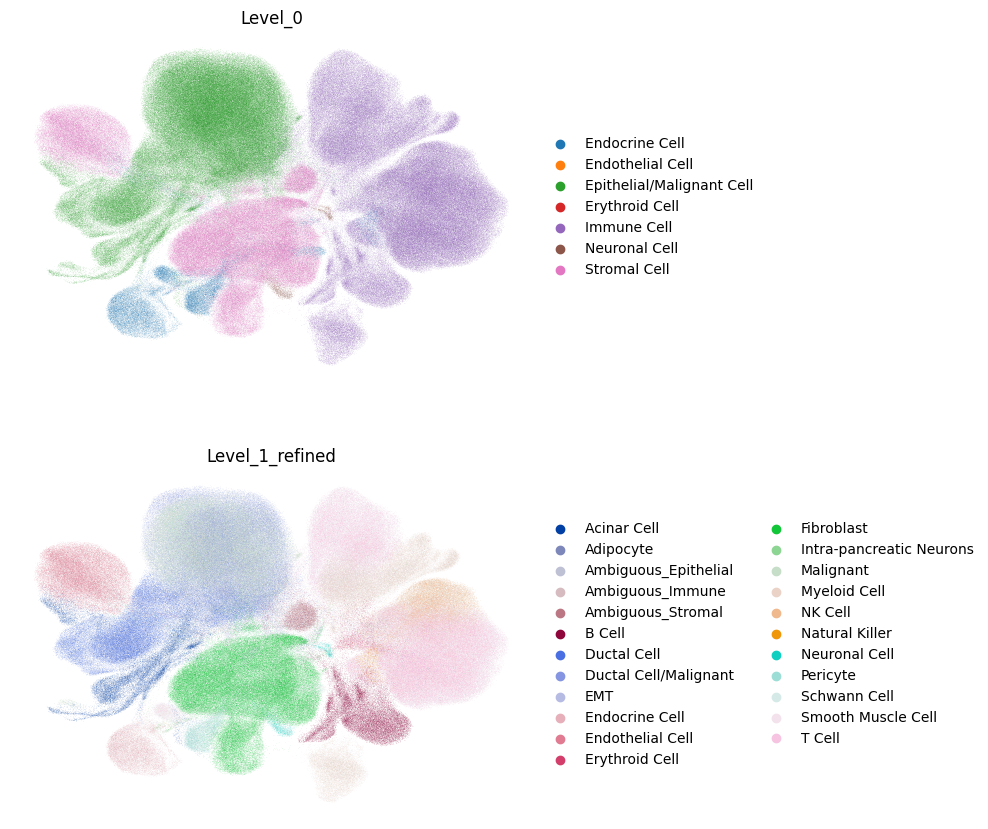

In [54]:
sc.pl.umap(adata, color=['Level_0','Level_1_refined'], frameon=False, ncols=1)

# Mark the manual genes in Manual_Genes Column

In [56]:
valid_genes_sc = [gene for gene in all_genes if gene in adata_sc.var_names]
valid_genes_sn = [gene for gene in all_genes if gene in adata_sn.var_names]
print(f"Total valied genes combined: {len(valid_genes_sc)}")
print(f"Total valied genes combined: {len(valid_genes_sn)}")

Total valied genes combined: 2505
Total valied genes combined: 2505


In [68]:
all_genes = list(set(valid_genes_sc) & set(valid_genes_sn))

In [71]:
adata.var['Manual_Genes'] = adata.var.index.isin(all_genes)

# Refine Obs Cols

In [96]:
df1 = pd.DataFrame(adata_sc.obs.columns, columns=["Column"])
df2 = pd.DataFrame(adata_sn.obs.columns, columns=["Column"])
df = df1.join(df2, lsuffix="_adata_sc", rsuffix="_adata_sn")

In [101]:
cols_removed = []
for col in adata.obs.columns:
    if adata.obs[col].isna().all():
        print(f"Column '{col}' contains only NaN values.")
        cols_removed.append(col)

In [106]:
obs_cols_removed= ['total_counts']

# Var columns extended by -0 from adata_sc and -1 from adata_sn because the var values are different and caluclated separately for SC and SN

In [116]:
# Rename the suffixes to indicate the dataset explicitly
adata.var.columns = adata.var.columns.str.replace("-0", "_adata_sc", regex=False)
adata.var.columns = adata.var.columns.str.replace("-1", "_adata_sn", regex=False)

In [12]:
obsm_removed = ['X_harmony', 'X_pca', 'X_cnv', 'X_cnv_pca', 'X_cnv_umap']
for i in obsm_removed:
    del adata.obsm[i]

In [15]:
adata.obs.drop('n_counts', axis=1, inplace=True)

# Filter empty droplets

In [19]:
adata.obs['MALAT1_lognorm'] = (adata[:, 'MALAT1'].layers['log_norm']).toarray()

Condition: scRNA-seq


/tmp/ipykernel_4176364/3391207882.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(adata[adata.obs.Condition == condition].obs['MALAT1_lognorm'], shade=True, color='blue', label='MALAT1_lognorm')


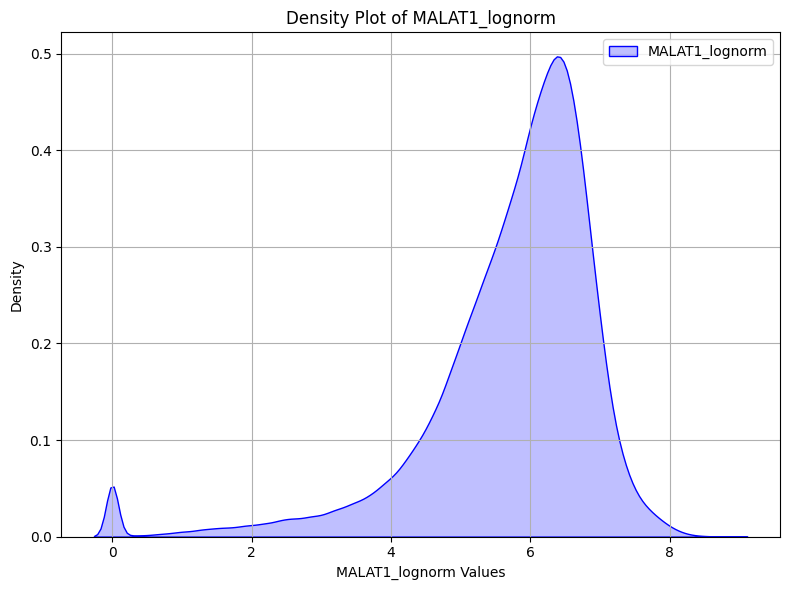

Condition: snRNA-seq


/tmp/ipykernel_4176364/3391207882.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(adata[adata.obs.Condition == condition].obs['MALAT1_lognorm'], shade=True, color='blue', label='MALAT1_lognorm')


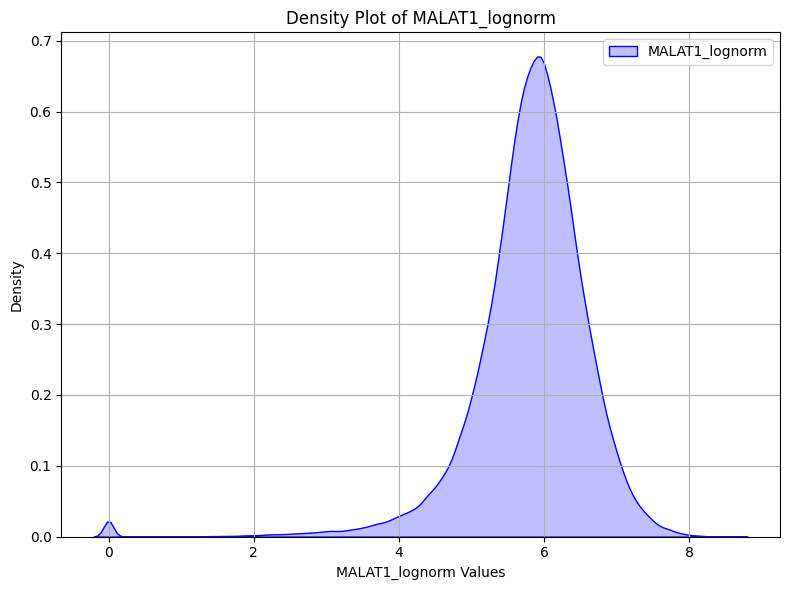

In [4]:
for condition in adata.obs.Condition.unique():
    print(f"Condition: {condition}")
    plt.figure(figsize=(8, 6))
    sb.kdeplot(adata[adata.obs.Condition == condition].obs['MALAT1_lognorm'], shade=True, color='blue', label='MALAT1_lognorm')
    plt.title('Density Plot of MALAT1_lognorm')
    plt.xlabel('MALAT1_lognorm Values')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [20]:
adata.obs['empty_droplet'] = np.where(
    (adata.obs['Condition'] == 'scRNA-seq') & (adata.obs['MALAT1_lognorm'] > 3.5), False,
    np.where(
        (adata.obs['Condition'] != 'scRNA-seq') & (adata.obs['MALAT1_lognorm'] >= 4), False, True
    )
)


/tmp/ipykernel_4176364/1868570021.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(adata[adata.obs.n_genes_by_counts <= 2000].obs['n_genes_by_counts'], shade=True, color='blue', label='n_genes_by_counts')


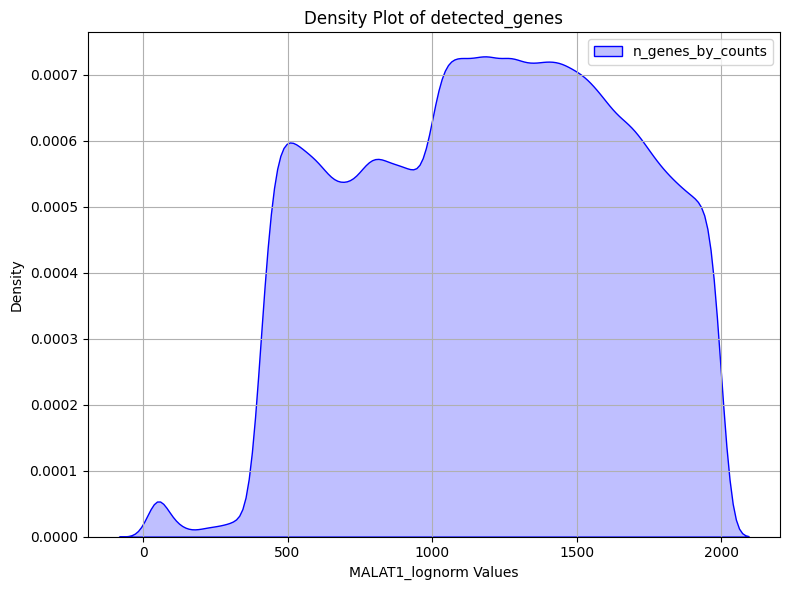

In [12]:
plt.figure(figsize=(8, 6))
sb.kdeplot(adata[adata.obs.n_genes_by_counts <= 2000].obs['n_genes_by_counts'], shade=True, color='blue', label='n_genes_by_counts')
plt.title('Density Plot of detected_genes')
plt.xlabel('MALAT1_lognorm Values')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
adata = adata[~adata.obs.empty_droplet].copy()

In [24]:
sc.pp.filter_cells(adata, min_genes=400)

# Adjust patient ID and add Metadata

In [177]:
metadata = pd.read_csv('metadata_human.csv', index_col=0)

## Adjust PID

In [87]:
adata.obs.rename(columns={'Condition': 'Technology', 'ID':'Unique_ID'}, inplace=True)
adata.obs["ID_harmonised"] = adata.obs["Unique_ID"].copy()

In [153]:
#rename Regev
adata.obs['Dataset'] = adata.obs.Dataset.replace('Regev', 'Hwang')
adata.obs['ID_harmonised'] = np.where(
    adata.obs['ID_batch_covariate'].str.contains('Hwang'),
    [f"PDAC_{cell[0]}_{cell[1:]}" for cell in adata.obs['ID_harmonised']],
    adata.obs['ID_harmonised']
)
adata.obs['ID_batch_covariate'] = np.where(
    adata.obs['ID_batch_covariate'].str.contains('Hwang'),
    [f"{cell}_Hwang_snRNA-seq" for cell in adata.obs['ID_harmonised']],
    adata.obs['ID_batch_covariate']
)

In [111]:
#rename Lee
adata.obs['ID_harmonised'] = adata.obs['Unique_ID'].replace({
    'P1_filtered_feature_bc_matrix': "P1",
    'P2_filtered_feature_bc_matrix': "P2",
    'P3_filtered_feature_bc_matrix': "P3",
    'P4_filtered_feature_bc_matrix': "P4",
    'P5_filtered_feature_bc_matrix': "P5",
    })
adata.obs['ID_batch_covariate'] = [ID[:2] + ID[-14:] if 'Lee' in ID else ID for ID in adata.obs.ID_batch_covariate]

In [112]:
#rename Simeone
adata.obs['ID_harmonised'] = [ID[ID.find('P'):] if 'GSM620' in ID else ID for ID in adata.obs.ID_harmonised]
adata.obs['ID_batch_covariate'] = [ID[ID.find('P'):] if 'GSM620' in ID else ID for ID in adata.obs.ID_batch_covariate]


In [133]:
#rename Caronni
sample_mapping = {
    'GSM6727546_PDAC': 'PDAC47',
    'GSM6727547_PDAC': 'PDAC48',
    'GSM6727548_PDAC': 'PDAC50',
    'GSM6727549_PDAC': 'PDAC51',
    'GSM6727550_PDAC': 'PDAC55',
    'GSM6727551_PDAC': 'PDAC60',
    'GSM6727542_LPDAC': 'LPDAC15',
    'GSM6727543_LPDAC': 'LPDAC25',
    'GSM6727544_LPDAC': 'LPDAC26',
    'GSM6727545_LPDAC': 'LPDAC30'
}
adata.obs['ID_harmonised'] = adata.obs['ID_harmonised'].replace(sample_mapping)
adata.obs['ID_batch_covariate'] = [sample_mapping[ID[:ID.find('_Caronni')]] + '_Caronni_scRNA-seq' if 'Caronni' in ID else ID for ID in adata.obs.ID_batch_covariate]

In [140]:
#rename Lin
sample_mapping = {
    'GSM4679532': 'P01',
    'GSM4679533': 'P02',
    'GSM4679534': 'P03',
    'GSM4679535': 'P04',
    'GSM4679536': 'P05',
    'GSM4679537': 'P06',
    'GSM4679538': 'P07',
    'GSM4679539': 'P08',
    'GSM4679540': 'P09',
    'GSM4679541': 'P10',
    'GSM4679542': 'M01',
    'GSM4679543': 'M02',
    'GSM4679544': 'M03',
    'GSM4679545': 'M04',
    'GSM4679546': 'M05',
    'GSM4679547': 'M06'
}

adata.obs['ID_harmonised'] = adata.obs['ID_harmonised'].replace(sample_mapping)
adata.obs['ID_batch_covariate'] = [sample_mapping[ID[:ID.find('_Lin')]] + '_Lin_scRNA-seq' if 'Lin' in ID else ID for ID in adata.obs.ID_batch_covariate]

In [117]:
mapping = {
    'Ding_snRNA-seq': 'Ding',
    'Peng_Normal': 'Peng',
    'Steele_Adj_Norm': 'Steele',
}
adata.obs['Dataset_unique'] = adata.obs.Dataset.replace(mapping)

In [134]:
def check_overlap(adata, metadata, dataset):
    metadata_patients = set(metadata[metadata.index == dataset].Patient)
    adata_patients = set(adata[adata.obs.Dataset_unique == dataset].obs.ID_harmonised)
    missing_patients = metadata_patients - adata_patients
    print(f"Missing patients in {dataset}: {missing_patients}")

In [162]:
for dataset in adata.obs.Dataset_unique.unique():
    check_overlap(adata, metadata, dataset)

Missing patients in Ding: {'HT160P1'}
Missing patients in Lee: {'LiM', 'LuM', 'PM', 'VM'}
Missing patients in Simeone: set()
Missing patients in Steele: {'20191225', '20191172', '20191204', '20191223', '19-469', '19-262', '19-249', '20191262', '19-561', '20181107', '20181141', '20191245', '20181166', '20191176t1', '19-384', '19-732'}
Missing patients in Peng: set()
Missing patients in Caronni: {'PDAC59', '22LIMET162', 'PDAC63', 'PDAC61', 'LPDAC27', 'PDAC65', 'LIMET139', 'PDAC57', 'LPDAC17', 'PDAC64', 'LPDAC21', '21LIMET49', 'PDAC58', '21LIMET163', 'PDAC62', '22LIMET10', '21LIMET325', 'PDAC56', 'LPDAC23', '22LIMET165'}
Missing patients in Zhang: set()
Missing patients in Lin: set()
Missing patients in Schlesinger: set()
Missing patients in Hwang: {'PDAC_U_21', 'PDAC_T_27', 'PDAC_U_19', 'PDAC_U_20', 'PDAC_T_26'}


## cleanup metadata

In [193]:
treatment_mapping = {
    'neoadjuvant gem/abraxane': 'Neoadjuvant Gem/Abraxane',
    'Neoadjuvant gemcitabine and nab-\r\npaclitaxel': 'Neoadjuvant Gem/Abraxane',
    's/p mFOLFIRINOX -> chemoradiation with gemzar + radiation': 'FOLFIRINOX + Chemoradiation',
    's/p gemcitabine/paclitaxel': 'Gem/Abraxane',
    'FOLFOXIRI -> nab-paclitaxel/gemcitabine-> Whipple': 'FOLFIRINOX + Gem/Abraxane + Whipple',
    'gemcitabine/paclitaxel': 'Gem/Abraxane',
    '5-fluorouracil/liposmal irinotecan': '5-FU/Liposomal Irinotecan',
    'evofosfamide/ipilimumab': 'Evofosfamide/Ipilimumab',
    'capecitabine': 'Capecitabine',
    'FOLFIRINOX + radiotherapy with concurrent capecitabine or 5-FU': 'FOLFIRINOX + Radiotherapy + Capecitabine/5-FU',
    'FOLFIRINOX + losartan + radiotherapy with concurrent capecitabine or 5-FU': 'FOLFIRINOX + Losartan + Radiotherapy + Capecitabine/5-FU',
    'FOLFIRINOX + stereotactic body radiotherapy + nivolumab': 'FOLFIRINOX + SBRT + Nivolumab',
    'FOLFIRINOX + stereotactic body radiotherapy + losartan + nivolumab; Other, treatment regimen consisting of chemotherapy and/or radiotherapy combination not otherwise specified': 'FOLFIRINOX + SBRT + Losartan + Nivolumab',
    'Other': 'Other',
    'FOLFIRINOX': 'FOLFIRINOX',
    'Chemo-RT': 'FOLFIRINOX + RT',
    'Gem_abrax': 'Gem/Abraxane',
    'FOLFIRINOX then Gem_abrax': 'FOLFIRINOX + Gem/Abraxane',
    'FOLIRINOX, Gem/Abraxane': 'FOLFIRINOX + Gem/Abraxane',
    'FOLFIRINOX, SBRT': 'FOLFIRINOX + SBRT',
    'mFOLFIRINOX, FOLFIRI': 'FOLFIRINOX',
    'FOLFIRONOX, Gemcitabine': 'FOLFIRINOX + Gemcitabine',
    'Folfirinox-based': 'FOLFIRINOX',
    'Gemcitabine/Abraxane': 'Gem/Abraxane',
    'PAXG': 'Abraxane',
    'GEMCITABINA + NAB PACLITAXEL': 'Gem/Abraxane',
    np.nan: 'Untreated'
}

In [187]:
def map_age_to_decade(age):
    try:
        age = int(age)
        return f"{age // 10 * 10}s"
    except ValueError:
        return age

In [194]:
metadata['Gender/sex'] = metadata['Gender/sex'].replace(np.nan, 'Unknown')
metadata['Diabetes'] = metadata['Diabetes'].replace(np.nan, 'Unknown')
metadata['Age'] = metadata['Age'].apply(map_age_to_decade).replace(np.nan, 'Unknown')
metadata['tissue'] = metadata['tissue'].replace(
    {
        'pancreas': 'Pancreas',
        'duodenum': 'Duodenum',
        'common bile duct': 'Common Bile Duct',
    }
)
metadata['Which treatment/radiation'] = metadata['Which treatment/radiation'].replace(treatment_mapping)

In [238]:
def map_metadata(adata, metadata, field, obs_name, Dataset):
    mapping = {k:v for k,v in zip(metadata[metadata.index == Dataset].Patient, metadata[metadata.index == Dataset][field])}
    adata.obs.loc[adata.obs.Dataset == Dataset, obs_name] = 'Unknown'
    adata.obs.loc[adata.obs.Dataset == Dataset, obs_name] = adata.obs.loc[adata.obs.Dataset == Dataset, 'ID_harmonised'].map(mapping)

In [246]:
# Tissue
for dataset in adata.obs.Dataset_unique.unique():
    map_metadata(adata, metadata, 'tissue', 'Tissue', dataset)
adata.obs.Tissue.fillna('Unknown', inplace=True)
# Age
for dataset in adata.obs.Dataset_unique.unique():
    map_metadata(adata, metadata, 'Age', 'Age', dataset)
adata.obs.Age.fillna('Unknown', inplace=True)
#Sex
for dataset in adata.obs.Dataset_unique.unique():
    map_metadata(adata, metadata, 'Gender/sex', 'Sex', dataset)
adata.obs.Sex.fillna('Unknown', inplace=True)
#Diabetes
for dataset in adata.obs.Dataset_unique.unique():
    map_metadata(adata, metadata, 'Diabetes', 'Diabetes', dataset)
adata.obs.Diabetes.fillna('Unknown', inplace=True)
#Treatment
for dataset in adata.obs.Dataset_unique.unique():
    map_metadata(adata, metadata, 'Which treatment/radiation', 'Treatment', dataset)
adata.obs.Treatment.fillna('Unknown', inplace=True)

# Save object

In [27]:
adata.write_h5ad('/mnt/storage/Daniele/atlases/human/adata_all_genes_scpoli_final.h5ad', compression='gzip')

# Check metadata

In [2]:
adata = sc.read_h5ad('/mnt/storage/Daniele/atlases/human/adata_all_genes_scpoli_final.h5ad')

In [3]:
metadata = ['Tissue', 'Age', 'Sex', 'Diabetes', 'Treatment']

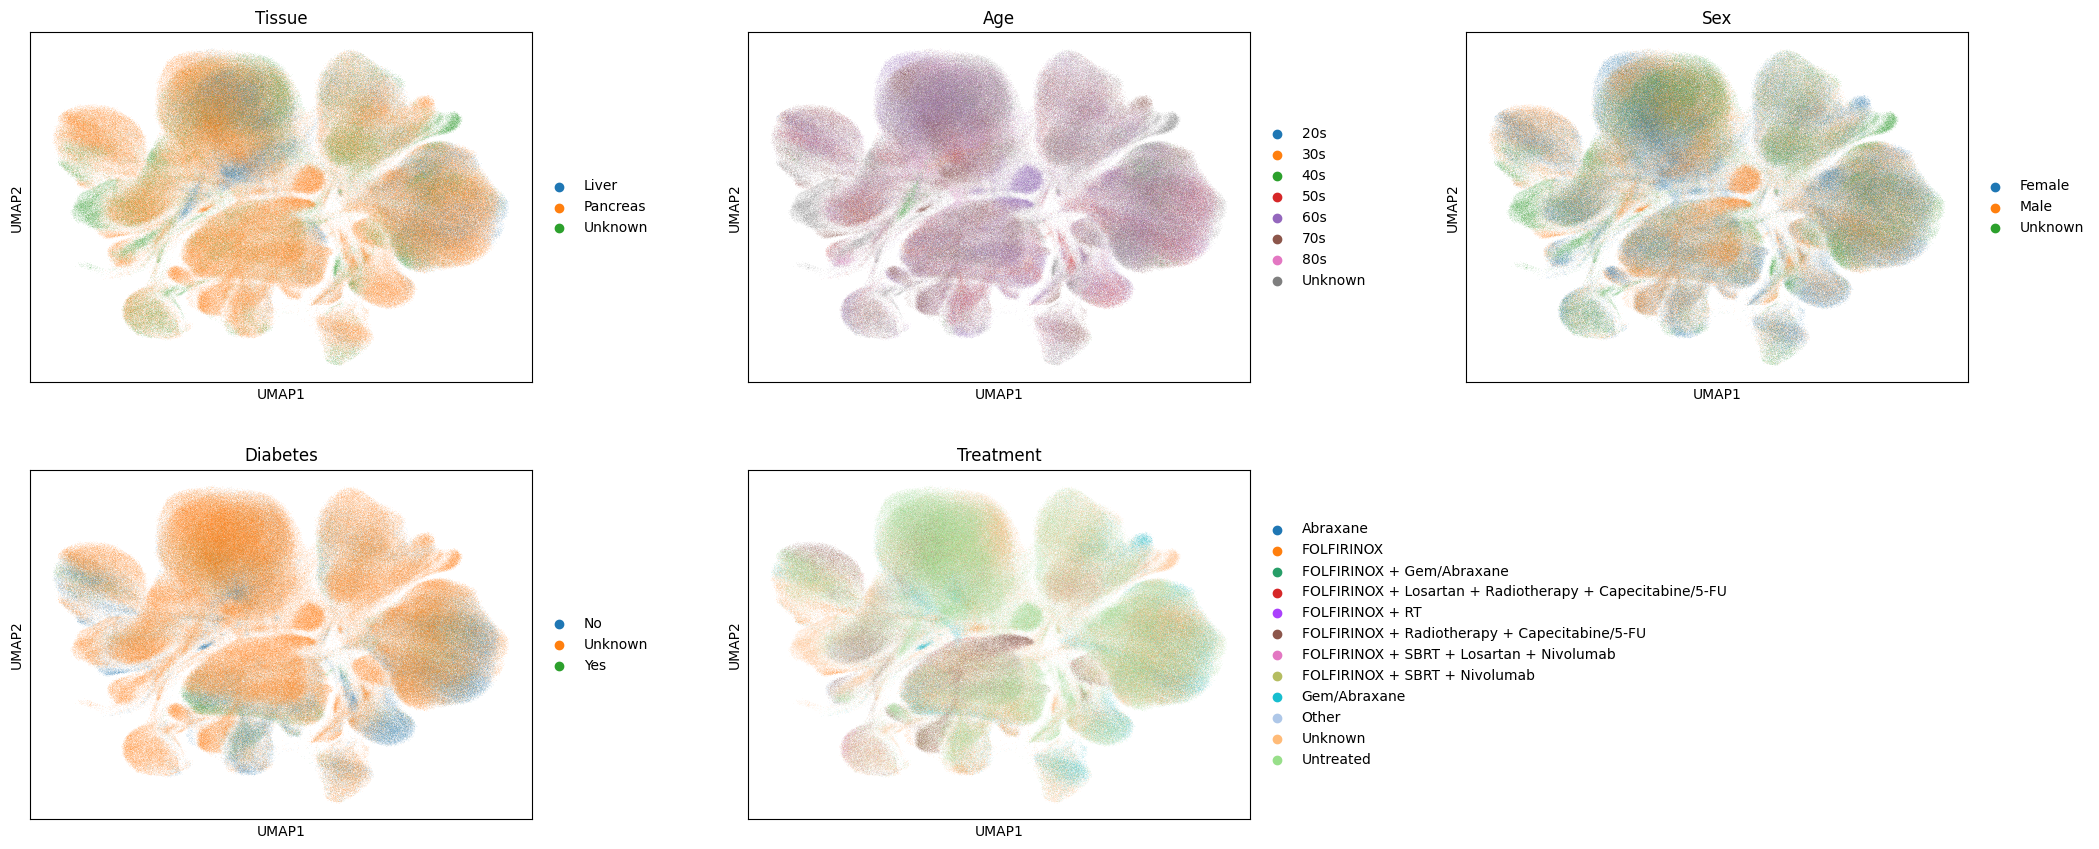

In [4]:
sc.pl.umap(adata, color = metadata, ncols=3, wspace = .3)